In [1]:
import pandas as pd
import numpy as np
import re
import os

from toolz import *
from toolz.curried import *

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Process the dataframes based on <a href="https://datameka.com/competition/9389d2dc-5cfe-41d5-b057-ada6500ebb15?tabIndex=2">Jacob's baseline code</a>

In [2]:
# paths to all the csvs files provided in the challenge.
trainPath   = "train.csv"
testPath    = "test.csv" 
microPath   = "properties.csv"
geoPath     = "geo_attributes.csv"

## load train&test_keys that contain unique identifier for each observation
train_keys = pd.read_csv(trainPath).assign(train = 1)
test_keys  = pd.read_csv(testPath).assign(train = 0).assign(price = pd.NA)
keys       = pd.concat([train_keys, test_keys])
keys       = keys.rename(columns = {"contractDate" : "date"})

## merge key with micro to borrow the date information in key.
_micro = pd.read_csv(microPath)
micro  = pd.merge(_micro, keys, on = "property_key")

# load geo
geo = pd.read_csv(geoPath)

In [3]:
def preprocess_micro(micro):    
    """
    preprocess micro data properties.csv
    """
    def _floorRange(row, thresFloor = 41):
        """
        some floorRanges are too rare to be used as categorical variables
        Hence merging floorRage above the "thresFloor" into one.
        """
        floorRange = row["floorRange"]    
        if floorRange != "-":
            floorMin = int(re.search("(\d+)-", floorRange).groups()[0])
            if floorMin >= thresFloor:
                row["floorRange"] = f"{thresFloor}-99"    
        return row

    def _tenure(row):
        """
        some tenures are too rare to be used as variables.
        Hence simply making tenure feature to 1 if freehold else 0.
        """
        tenure = row["tenure"]    
        if tenure == "Freehold" : row["tenure"] = 1
        else                    : row["tenure"] = 0        
        return row
        
    micro = (micro
             .apply(_floorRange, axis = 1)
             .apply(_tenure, axis = 1))
    
    micro["date"] = pd.to_datetime(micro["date"])
    
    return micro

micro = preprocess_micro(micro)

In [4]:
# delete 'district' and 'project' columns from geo dataframe
del geo['district']
del geo['project']

# merge geo and micro dataframes on 'street' column and assign to merged_df variable
df = pd.merge(geo, micro, on='street', how='left')

# Remove rows with missing lat and lng values
df = df.dropna(subset=['lat', 'lng', 'price'])

### Feature Engineering

#### 1. Relationship of marketSegment with district

<b>Core Central Region (CCR): City, Downtown Core and Sentosa: </b>includes the traditional prime areas of Singapore (i.e. postal districts 9, 10 and 11), and the Downtown Core (including parts of Bugis, south of Ophir Road), as well as Sentosa. These districts are where most high-end, luxury properties in Singapore can be found.

<b>Rest of Central Region (RCR): Central Areas That Are Not Part of CCR: </b>area sandwiched between the CCR and the Outside Central Region (OCR). The RCR is regarded as the intermediate, or mid-tier, region in terms of pricing, between the mass market condos in the OCR region and the high-value properties in the CCR. Various buyer groups are interested in RCR properties – including investors, owner-occupiers, young families, and empty nesters.

<b>Outside Central Region (OCR): Everywhere Else in Singapore: </b> areas where mass-market condos at the lower range of price points are mostly located, including executive condominiums (ECs). The Government has plans to bring high-value jobs to the OCR, in the form of Jurong’s transformation into the second CBD, Punggol Digital District and Woodlands Regional Centre.

<a href="https://www.propertyguru.com.sg/property-guides/ccr-ocr-rcr-region-singapore-ura-map-21045">Source: www.propertyguru.com.sg</a>

In [5]:
# Converts the district column to a string data type
df['district'] = df['district'].astype(str)

# Define the dictionary for the postal districts and description
postal_districts = {
    '1': 'Raffles Place, Cecil, Marina, People’s Park',
    '2': 'Anson, Tanjong Pagar',
    '3': 'Queenstown, Tiong Bahru',
    '4': 'Telok Blangah, Harbourfront',
    '5': 'Pasir Panjang, Hong Leong Garden, Clementi New Town',
    '6': 'High Street, Beach Road (part)',
    '7': 'Middle Road, Golden Mile',
    '8': 'Little India',
    '9': 'Orchard, Cairnhill, River Valley',
    '10': 'Ardmore, Bukit Timah, Holland Road, Tanglin',
    '11': 'Watten Estate, Novena, Thomson',
    '12': 'Balestier, Toa Payoh, Serangoon',
    '13': 'Macpherson, Braddell',
    '14': 'Geylang, Eunos',
    '15': 'Katong, Joo Chiat, Amber Road',
    '16': 'Bedok, Upper East Coast, Eastwood, Kew Drive',
    '17': 'Loyang, Changi',
    '18': 'Tampines, Pasir Ris',
    '19': 'Serangoon Garden, Hougang, Punggol',
    '20': 'Bishan, Ang Mo Kio',
    '21': 'Upper Bukit Timah, Clementi Park, Ulu Pandan',
    '22': 'Jurong',
    '23': 'Hillview, Dairy Farm, Bukit Panjang, Choa Chu Kang',
    '24': 'Lim Chu Kang, Tengah',
    '25': 'Kranji, Woodgrove',
    '26': 'Upper Thomson, Springleaf',
    '27': 'Yishun, Sembawang',
    '28': 'Seletar'
}

# Create a new column called "marketSegment_desc" in your dataframe based on the "district" column
df['marketSegment_desc'] = ''

# Update the "marketSegment_desc" column with the appropriate region based on the postal district
for index, row in df.iterrows():
    district = row['district']
    for key, value in postal_districts.items():
        if str(key) == str(district):
            df.at[index, 'marketSegment_desc'] = value
            break

#### 2. Type of housing in Singapore

Based on the definitions below, i will create 4 categories as follows:
- Public
- EC
- Condo
- Landed

<table>
  <thead>
    <tr>
      <th>Category</th>
      <th style="text-align:left;">Types of Housing</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="text-align:left;">Public (HDB)</td>
      <td style="text-align:left;">2-room flexi flat, 3-room flat, 4-room flat, 5-room flat, 3Gen flat, Executive flat, Design, Build and Sell Scheme (DBSS) flat, executive maisonette, jumbo flat, HDB terrace house</td>
    </tr>
    <tr>
      <td style="text-align:left;">Public-Private Hybrid</td>
      <td style="text-align:left;">Executive condominium (EC)</td>
    </tr>
    <tr>
      <td style="text-align:left;">Private</td>
      <td style="text-align:left;">Condominium, Apartment, Terrace, Semi-detached, Cluster, Townhouse, Shophouse, Bungalow, Good Class Bungalow (GCB), Housing and Urban Development Company (HUDC) flat</td>
    </tr>
  </tbody>
</table>

<a href="https://www.propertyguru.com.sg/property-guides/the-different-types-of-housing-in-singapore-9916">Source: www.propertyguru.com.sg</a>

In [6]:
# Define dictionary mapping propertyType to category
prop_type_dict = {
    'Apartment_RESIDENTIAL APARTMENTS': 'Public',
    'Terrace': 'Landed',
    'Detached': 'Landed',
    'Semi-detached': 'Landed',
    'Executive Condominium': 'EC',
    'Condominium': 'Condo',
    'Strata': 'Condo'
}

# Create conditions and corresponding values for numpy.select()
conditions = [
    (df['propertyType'] == 'Apartment') & (df['project'] == 'RESIDENTIAL APARTMENTS') & (df['price'] < 1500000),
    (df['propertyType'].isin(['Terrace', 'Detached', 'Semi-detached']) | (df['floorRange'] == '-')),
    (df['propertyType'] == 'Executive Condominium'),
    (df['propertyType'].str.contains('Strata|Condominium|Apartment')),
    (df['propertyType'].notnull())
]

choices = ['Public', 'Landed', 'EC', 'Condo', 'others']

df['property_type_cat'] = np.select(conditions, choices, default='others')


# Map propertyType values to corresponding dictionary key and join with _ to create key for mapping to category
df['prop_type_key'] = df['propertyType'] + '_' + df['project']
df['property_type_cat'] = df['prop_type_key'].map(prop_type_dict).fillna(df['property_type_cat'])

# Drop prop_type_key column
df = df.drop(columns='prop_type_key')

#### 3. Sizes of Housing in Singapore

Singapore's housing market has been characterized by a steady decrease in home sizes over the years. This trend has been primarily driven by rising land costs and the growing demand for housing. 

<br><b>How Big Are HDB Flats?</b></br>

The Housing and Development Board (HDB) reported that the average size of new flats has decreased by approximately 10 square meters over the past decade. For example, a 2-room flexi flat is typically around 36-45 square meters in size, suitable for one or two individuals. A 3-room flat is around 60-65 square meters, which can accommodate a small family of three to four members. A 4-room flat is around 90-100 square meters, suitable for a family of four to five members, and a 5-room flat is around 110-120 square meters, which can accommodate a larger family with up to six members.

<br><b>How Big Are Condos?</b></br>

In the case of condos, a 2014 study found that the median size of new condos in Singapore has shrunk significantly over the last decade, with five-bedroom units shrinking by 22.9% from about 189 to 146 sqm after the introduction of the Total Debt Servicing Ratio (TDSR) in June 2013. Meanwhile, two-bedroom units shrank 11.2% from about 90 to 80 sqm. Developers are building more studio, one-, and two-bedroom condo units in response to demand from singles and households without children. This also caters to the investor group as smaller units command a higher price per square foot and enjoy stronger demand on the rental market than they did two decades ago due to the high number of foreigners working in Singapore. The Urban Redevelopment Authority has put regulations on the number of units that can be built on each plot of land. However, smaller condo sizes are here to stay due to Singapore’s demographic changes over the past few decades.

<a href="https://www.propertyguru.com.sg/property-guides/are-hdb-flats-condos-getting-smaller-48893">Source: www.propertyguru.com.sg</a>

In [7]:
def categorize_area(area):
    if area < 50:
        return 'small'
    elif area >=50 and area < 100:
        return 'medium'
    elif area >= 100 and area < 150:
        return 'medium_large'
    else:
        return 'large'

df['area_cat'] = df['area'].apply(categorize_area)

#### 4. Price Per Square Feet (PSF)

In the context of real estate, the term "quantum" refers to the price of a property, and it is an essential component in determining the affordability of a property for potential buyers. The column "price" in the dataset represents the quantum of the properties listed.

On the other hand, the column "area" provides the size of the property in square meters. However, in Singapore, property prices are typically quoted in price per square foot (psf) rather than price per square meter (psm). This is because the price per square foot is a more common unit of measurement for real estate transactions in Singapore.

To convert the area in square meters to square feet, we can use the conversion factor of 1 square meter = 10.764 square feet. Therefore, to obtain the price per square foot (psf) of a property, we need to divide the quantum by the area in square meters and multiply it by the conversion factor. This would result in a new column called "price_psf" that is more commonly used in the Singapore real estate market.

In [8]:
df['price_psf'] = df['price'] / (df['area']*10.7639)

#### 5. Correlation plot

We find moderate correlations between price and area and marketSegment

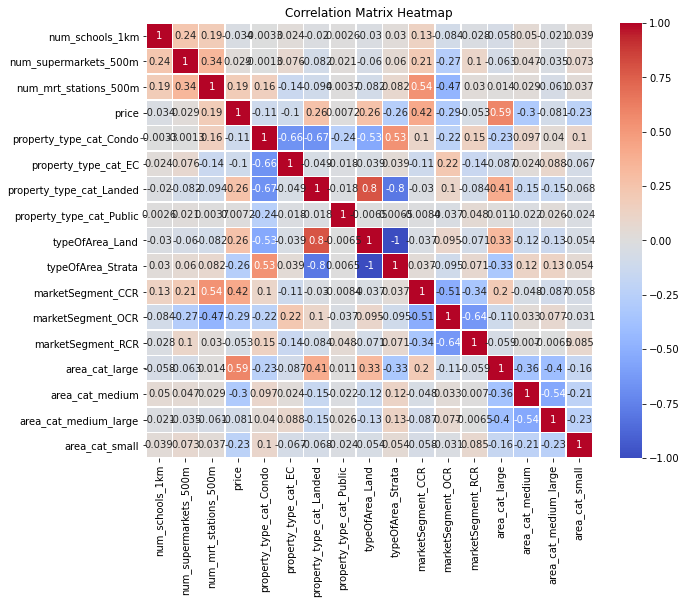

In [9]:
# Select relevant columns
cols = ['num_schools_1km', 'num_supermarkets_500m', 'num_mrt_stations_500m', 'area_cat', 'price', 'property_type_cat', 'typeOfArea', 'marketSegment']

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df[cols], columns=['property_type_cat', 'typeOfArea', 'marketSegment', 'area_cat'])

# Compute correlation matrix
corr = df_encoded.corr()

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm', annot=True, linewidths=.5, ax=ax)
plt.title('Correlation Matrix Heatmap')
plt.show()

#### 6. What is missing from the dataset for better feature engineering
- Tenure (99/999/freehold)
- Plot ratio of individual projects to categories floorRange into Ground, low, middle or high
- Indication for number of bedrooms
- Gain/loss information of the transactions

### EDA

##### 1. Overview of price trend by districts

A distinct upward trend can be observed in many RCR and OCR districts, indicating a potential increase in demand in those areas. On the other hand, price fluctuations in CCR are generally more stable.

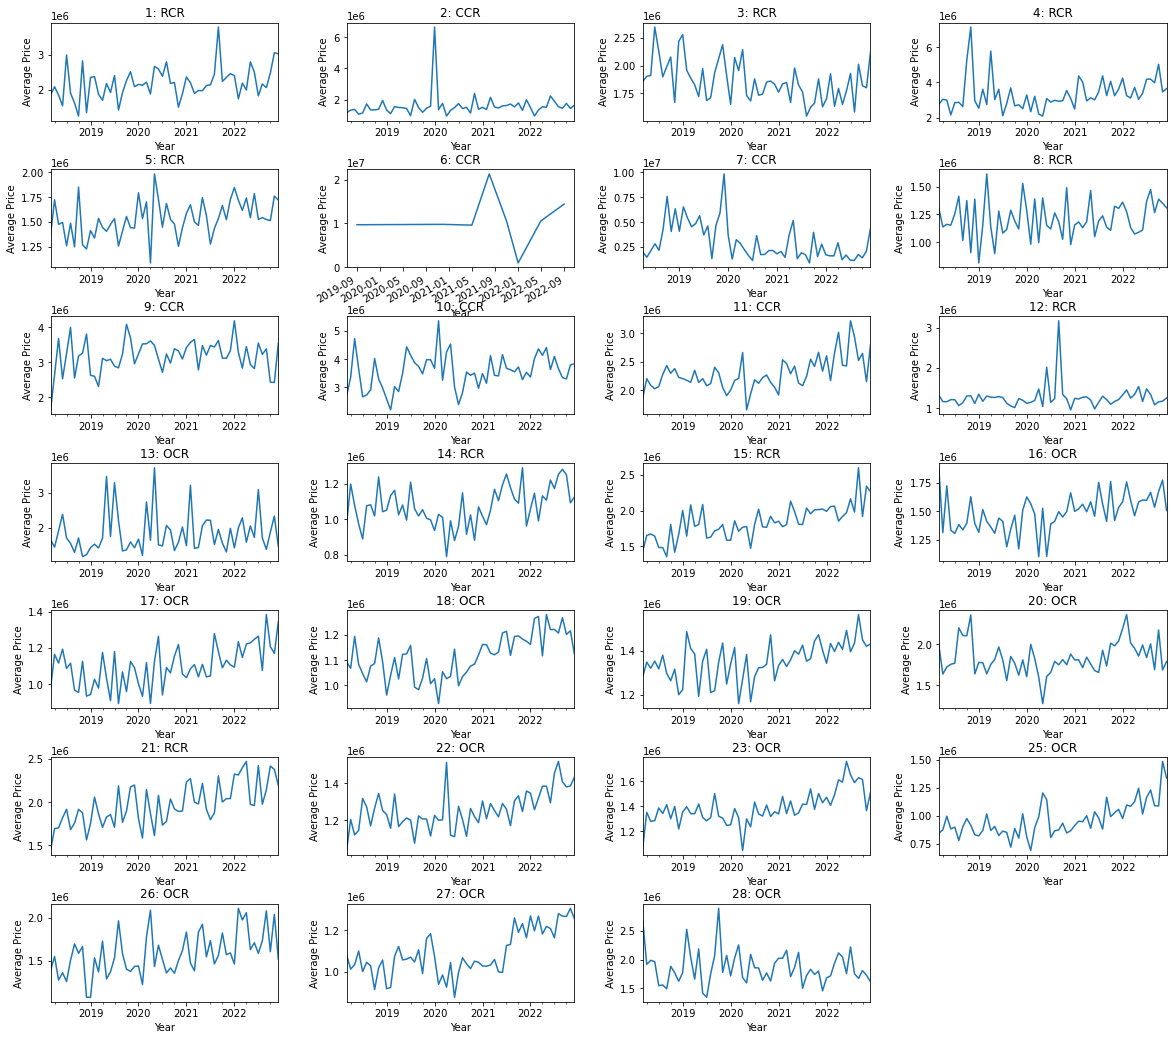

In [10]:
# convert date column to datetime type
df['date'] = pd.to_datetime(df['date'])

# create a list of all unique districts
districts = df['district'].unique().tolist()

# calculate the number of rows and columns for the subplot matrix
num_rows = 7
num_cols = 4
num_plots = num_rows * num_cols

# create a figure and axis object for each subplot
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20,20))

# sort the districts numerically
districts = sorted(districts, key=lambda x: int(x) if str(x).isdigit() else int(x.split()[0]))

for i, district in enumerate(districts[:num_plots]):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    df_district = df[df['district'] == district]
    mean_by_date = df_district.groupby('date')['price'].mean()
    ax.set_title(f"{district}: {df_district['marketSegment'].iloc[0]}")
    mean_by_date.plot(ax=ax)
    ax.set_xlabel('Year')
    ax.set_ylabel('Average Price')
    
# hide empty subplots
for i in range(len(districts), num_plots):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

# adjust spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# show the plot
plt.show()

##### 2. Price by marketSegment

When analyzing the trend in property prices across different market segments, it is important to take into account the size of the property. Looking at the average price per market segment, we can see that prices are increasing for all three regions. However, when we consider the average price per square foot (PSF), the price trend becomes even more pronounced. This highlights the importance of analyzing price trends in PSF, as it provides a better understanding of how prices are changing relative to the size of the property. By considering PSF, we can more accurately compare prices across properties of different sizes and better understand the market trends.

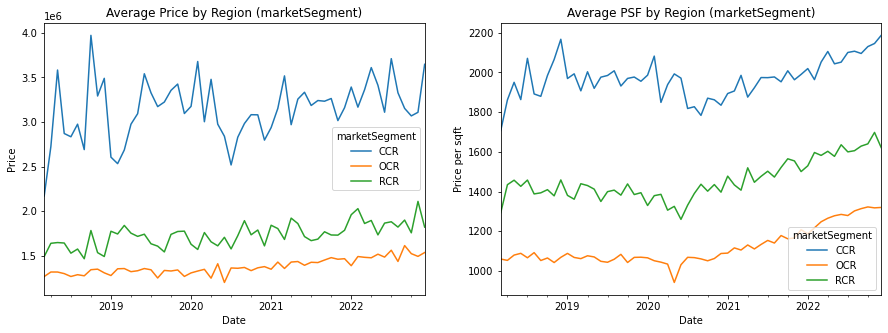

In [11]:
import matplotlib.pyplot as plt

# Group the data by region and date
grouped = df.groupby(['marketSegment', 'date']).agg({'price': 'mean', 'price_psf': 'mean'}).reset_index()

# Pivot the table to show the average price and psf for each region by date
pivoted = grouped.pivot_table(index='date', columns='marketSegment')

# Create subplots
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

# Plot the data for each region in the left subplot
pivoted['price'].plot(ax=axs[0], title='Average Price by Region (marketSegment)')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price')

# Plot the data for each region in the right subplot
pivoted['price_psf'].plot(ax=axs[1], title='Average PSF by Region (marketSegment)')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price per sqft')

plt.show()

##### 3. Average Price property type

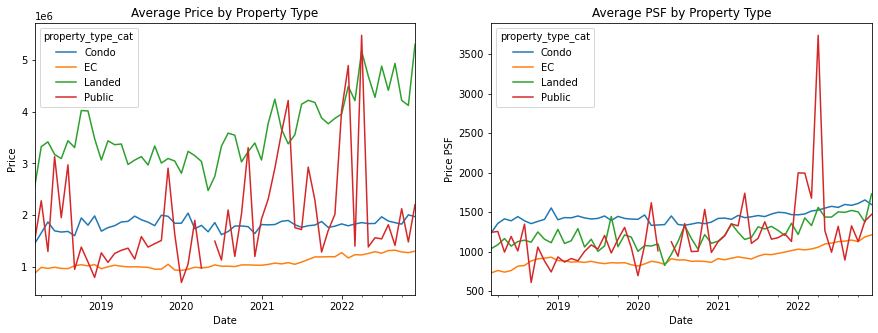

In [12]:
# Group the data by region and date
grouped = df.groupby(['property_type_cat', 'date']).agg({'price': 'mean'}).reset_index()

# Pivot the table to show the average price for each region by date
pivoted = grouped.pivot_table(index='date', columns='property_type_cat', values='price')

# Group the data by region and date
grouped_psf = df.groupby(['property_type_cat', 'date']).agg({'price_psf': 'mean'}).reset_index()

# Pivot the table to show the average price for each region by date
pivoted_psf = grouped_psf.pivot_table(index='date', columns='property_type_cat', values='price_psf')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))

# Plot the data for each region in the first subplot
pivoted.plot(ax=ax1, title='Average Price by Property Type')

# Plot the data for each region in the second subplot
pivoted_psf.plot(ax=ax2, title='Average PSF by Property Type')

# Set the axis labels for both subplots
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price PSF')

# Show the plots
plt.show()

##### 4. Average Price by size

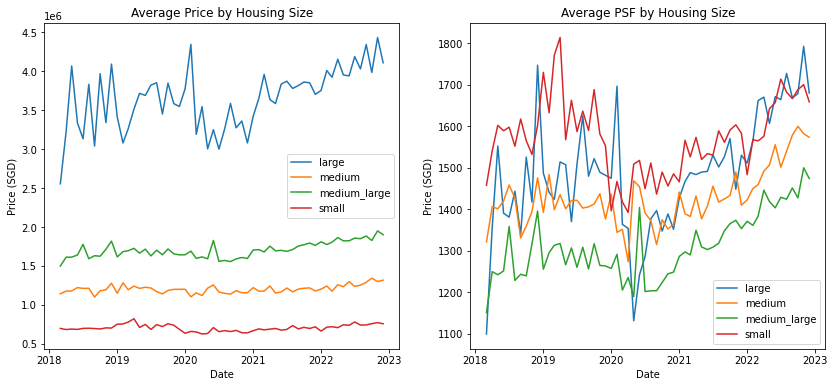

In [13]:
# group the data by area and date and calculate the mean price
grouped = df.groupby(['area_cat', 'date']).agg({'price': 'mean'})

# create a grid of subplots
fig, axs = plt.subplots(ncols=2, figsize=(14,6))

# plot the first chart on the first axis
for area, data in grouped.groupby('area_cat'):
    axs[0].plot(data.index.get_level_values('date'), data['price'], label=area)

# set the plot title, x-label, and y-label
axs[0].set_title('Average Price by Housing Size')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price (SGD)')

# set the legend for the first chart
axs[0].legend()

# group the data by area and date and calculate the mean PSF
grouped = df.groupby(['area_cat', 'date']).agg({'price_psf': 'mean'})

# plot the second chart on the second axis
for area, data in grouped.groupby('area_cat'):
    axs[1].plot(data.index.get_level_values('date'), data['price_psf'], label=area)

# set the plot title, x-label, and y-label
axs[1].set_title('Average PSF by Housing Size')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price (SGD)')

# set the legend for the second chart
axs[1].legend()

# display the plots
plt.show()

##### 5. Average Price by floorRange

Despite the popular preference for high floor units, our analysis indicates that there are no significant differences in price trend between low and high floor.

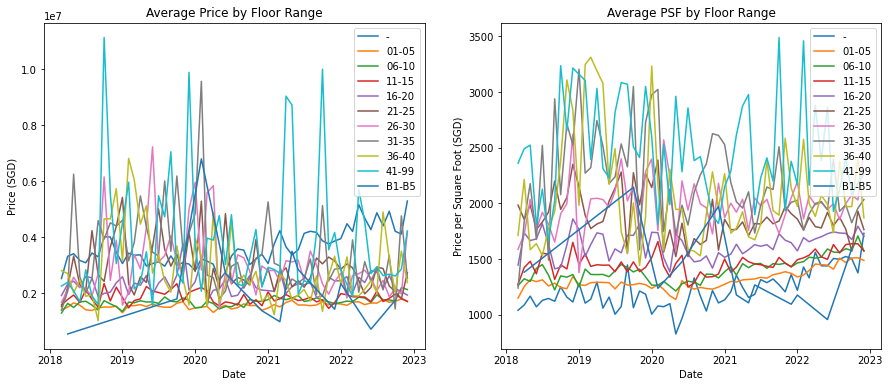

In [14]:
# group the data by area and date and calculate the mean price
grouped = df.groupby(['floorRange', 'date']).agg({'price': 'mean'})

# create subplots with two columns
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

# plot the data for average price
for area, data in grouped.groupby('floorRange'):
    axs[0].plot(data.index.get_level_values('date'), data['price'], label=area)

# set the plot title, x-label, and y-label for average price
axs[0].set_title('Average Price by Floor Range')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price (SGD)')

# set the legend for average price plot
axs[0].legend()

# group the data by area and date and calculate the mean price per square foot
grouped = df.groupby(['floorRange', 'date']).agg({'price_psf': 'mean'})

# plot the data for average price per square foot
for area, data in grouped.groupby('floorRange'):
    axs[1].plot(data.index.get_level_values('date'), data['price_psf'], label=area)

# set the plot title, x-label, and y-label for average price per square foot
axs[1].set_title('Average PSF by Floor Range')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price per Square Foot (SGD)')

# set the legend for average price per square foot plot
axs[1].legend()

# display the plots
plt.show()